# Training the Semi-Supervised GAN for Melanoma Image Classification

In [1]:
import os 
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [4]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt

import PIL
import torchvision
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


from os import listdir
from os.path import join
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"

print(device)

cpu


In [5]:
#set random seed for reproducibility
seed = 123
random.seed(seed)
torch.manual_seed(seed)

In [84]:
#set path to data folders
path = os.getcwd()
parent = os.path.abspath(os.path.join(path, os.pardir))

transform = transforms.ToTensor()

## Setting up an Image Pipeline

Preparing a data pipeline that handles the pre-processing and augmentation of the labele dataset. Dataset classes are custom classes inheriting from the abstract Pytorch class torch.utils.data.Dataset, overiding the `__len__` and `__getitem__` methods in order to be able toget the size of the dataset via `len(dataset)` and access each datasample as `dataset[index]`. If no transform specified, datasets returning images in the form of objects of type `PIL.PngImagePlugin.PngImageFile`. Turn the images into Pytorch tensors via the Dataset class transform argument.

### Unlabeled Data Set

In [88]:
def is_image(filename):
    return any(filename.endswith(extension) for extension in [".jpg",".JPG", ".jpeg", ".png"])

class UnlabeledDataset(Dataset):

    def __init__(self, dir_path, transform=None):
        """
        Args:
            dir_path (string): Directory containing the images.
            transform (optional): Transform to be applied on an image.
        """

        self.transform = transform
        
        # The list of all the image file names (but not the images themselves!) will be read
        # when the Dataset object is initialized
        self.image_filenames = [join(dir_path, f) for f in listdir(dir_path) if is_image(f)]

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):

        img_name = self.image_filenames[idx]
        
        # Here is where the image actually gets read:
        image = Image.open(img_name)

        if self.transform:
            image = self.transform(image)

        return image

In [8]:
unlabeled_data_path = os.path.join(path, parent, 'Data/unlabeled/')
unlabeled_set = UnlabeledDataset(dir_path= unlabeled_data_path, transform=transform)

print('Number of images in the unlabeled set: ', len(unlabeled_set))

Number of images in the unlabeled set:  7018


### Labeled Data Set

Benign images are named *\_0.jpg*, whereas images of melanoma have filenames ending with *\_1.jpg*. The __getitem__ method returns the image with a label. 

In [9]:
class LabeledDataset(Dataset):

    def __init__(self, dir_path, transform=None):
        """
        Args:
            dir_path (string): Directory containing the images.
            transform (optional): Optional transform to be applied
                on an image.
                
            If not transform PIL.PngImagePlugin.PngImageFile    
        """

        self.transform = transform
        
        # The list of all the image file names (but not the images themselves!) will be read
        # when the Dataset object is initialized
        self.image_filenames = [join(dir_path, f) for f in listdir(dir_path) if is_image(f)]

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):

        img_name = self.image_filenames[idx]
        
        # Here is where the image actually gets read:
        image = Image.open(img_name)

        if self.transform:
            image = self.transform(image)
            
        label = int(img_name[-5])

        return image, label
    

In [10]:
labeled_data_path = os.path.join(path, parent, 'Data/labeled/')
labeled_set = LabeledDataset(dir_path= labeled_data_path, transform=transform)

print('Number of images in the labeled set: ', len(labeled_set))

test_data_path = os.path.join(path, parent, 'Data/test/')

Number of images in the labeled set:  200


### Data Augmentation

With the `torchvision.transforms` package transformations applied at random with a chosen probability, augment the unlabeled and labeled data sets making sure that the augmented dataset follows the same distribution as the original.

In [11]:
#augment the labeled data by applying randomly a list of transformations with given probability
augmentation = transforms.Compose([transforms.RandomHorizontalFlip(p=0.5),
                                     transforms.RandomVerticalFlip(p=0.5),
                                     transforms.RandomRotation(0,360)])
                                    
transform = transforms.Compose([augmentation, transforms.ToTensor()])                                     

In [12]:
unlabeled_set = UnlabeledDataset(unlabeled_data_path, 
                                 transform=transform)

labeled_set = LabeledDataset(labeled_data_path,     
                             transform=transform)

train_set, val_set = torch.utils.data.random_split(labeled_set, [int(0.7*len(labeled_set)), int(0.3*len(labeled_set))])

test_set = LabeledDataset(test_data_path,
                          transform=transforms.Compose([transforms.ToTensor()]))

print('Number of unlabeled train images: ', len(unlabeled_set))
print('Number of labeled train images: ', len(train_set))
print('Number of valdation images: ', len(val_set))
print('Number of test images: ', len(test_set))

Number of unlabeled train images:  7018
Number of labeled train images:  140
Number of valdation images:  60
Number of test images:  600


### DataLoaders

torch.utils.data.DataLoader takes care of splitting the data into minibatches of a given size, shuffling it if needed, and loading it in parallel by using multiprocessing workers.

In [13]:
unlabeled_loader = DataLoader(unlabeled_set, 
                              batch_size=256, 
                              num_workers=0,
                              shuffle=True)

labeled_loader = DataLoader(train_set, 
                            batch_size=len(train_set), 
                            num_workers=0,
                            shuffle=True)

val_loader = DataLoader(val_set, 
                        batch_size=len(val_set), 
                        num_workers=0,
                        shuffle=True)

test_loader = DataLoader(dataset = test_set,
                         batch_size = len(test_set),
                         num_workers = 0,
                         shuffle=True)

In [14]:
print("size of a training image: ", labeled_loader.dataset[0][0].size())

size of a training image:  torch.Size([3, 32, 32])


In [15]:
print("Pixels value range for training image: ", labeled_loader.dataset[0][0].min(), labeled_loader.dataset[0][0].max())

Pixels value range for training image:  tensor(0.0784) tensor(0.8902)


(-0.5, 511.5, 103.5, -0.5)

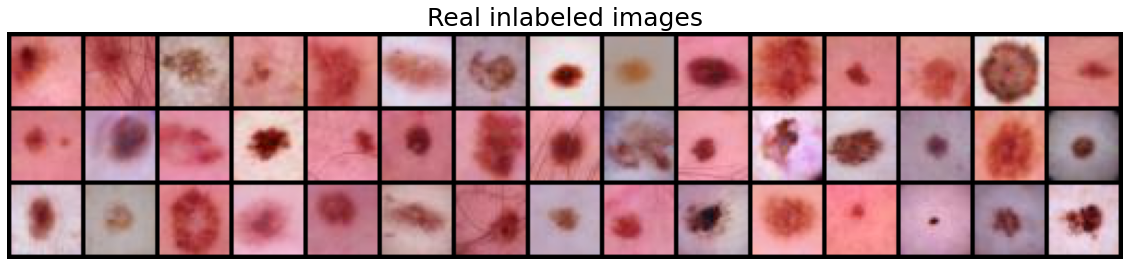

In [16]:
# Have a picky at the training images
dataiter = iter(unlabeled_loader)
images = dataiter.next()

image_grid = torchvision.utils.make_grid(images[0:45], nrow=15)

plt.figure(figsize=(20,10))
plt.title("Real inlabeled images", fontsize=25)
plt.imshow(image_grid.permute(1, 2, 0))
plt.axis("off")

## Unsupervised DCGAN

Makes use of the unlabeled data to boost the performance of the melanoma image classifier. An unsupervised DCGAN would generate mole-like images and train on the unlabeled dataset. The goal is not best results on generation task, but tuning the hyperparameters which will allow the generation of images in the desired domain.

In [18]:
# Number of channels of training images
nc = 3

# Latent vector dimensions  latent vector, i.e. size of generator input
z_dim = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

z_std = 1e-2

perturb_const = 1e-5

# Learning rate for optimizers
lr = 2e-4

# Beta1 hyperparam for Adam optimizers
beta1 = 0.3

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# batch of latent vectors used to visualize the progression of the generator
fixed_noise = torch.randn(64, z_dim, 1, 1, device=device)

num_epochs = 50

In [19]:
def weights_init(m, mean=0.0, std=0.02):
    
    """ Randomly initialize the weights of the Generator and Discriminator
        to normaly distributed with mean of 0 and std of 0.2 """
    
    classname = m.__class__.__name__
    
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, mean, std)
        
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, std)
        nn.init.constant_(m.bias.data, 0)

In [20]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        #self.fc1 = nn.Linear(z_dim, 256*7*7, bias= False)
        
        self.deconv1 = nn.ConvTranspose2d(in_channels=z_dim, out_channels=ngf*4, kernel_size=4, stride=1, padding=0, bias=False)
        self.batchn1 = nn.BatchNorm2d(ngf*4)
        self.deconv2 = nn.ConvTranspose2d(in_channels=ngf*4, out_channels=ngf*2,  kernel_size=4, stride=2, padding=1, bias=False)
        self.batchn2 = nn.BatchNorm2d(ngf*2)
        self.deconv3 = nn.ConvTranspose2d(in_channels=ngf*2, out_channels=ngf,  kernel_size=4, stride=2, padding=1, bias=False)
        self.batchn3 = nn.BatchNorm2d(ngf)
        self.deconv4 = nn.ConvTranspose2d(in_channels=ngf, out_channels=nc,  kernel_size=4, stride=2, padding=1, bias=False)
        
    def forward(self, input):
        
        x = self.deconv1(input)
        x = self.batchn1(x)
        x = F.leaky_relu(x) # default negative_slope of 0.01
        x = self.deconv2(x)
        x = self.batchn2(x)
        x = F.leaky_relu(x)
        x = self.deconv3(x)
        x = self.batchn3(x)
        x = F.leaky_relu(x)
        x = self.deconv4(x)
        
        output = torch.tanh(x) 
        
        return output

In [21]:
class unsup_Discriminator(nn.Module):
    
    def __init__(self):
        super(unsup_Discriminator, self).__init__()
        
        self.conv1 = nn.Conv2d(nc, ndf, kernel_size=2, stride=2, padding=2, bias=False)
        self.conv2 = nn.Conv2d(ndf, ndf*2, kernel_size=4, stride=2, padding=1, bias=False)
        self.batchn1 = nn.BatchNorm2d(ndf*2)
        self.conv3 = nn.Conv2d(ndf*2, ndf*4, kernel_size=4, stride=2, padding=1, bias=False)
        self.batchn2 = nn.BatchNorm2d(ndf*4)
        self.conv4 = nn.Conv2d(ndf*4, 1, kernel_size=4, stride=1, padding=0, bias=False)
        
        
    def forward(self, input):
        
        x = self.conv1(input)
        x = F.leaky_relu(x, 0.2, inplace=True)
        x = self.conv2(x)
        x = self.batchn1(x)
        x = F.leaky_relu(x, 0.2, inplace=True)
        x = self.conv3(x)
        x = self.batchn2(x)
        x = F.leaky_relu(x, 0.2, inplace=True)
        x = self.conv4(x)
        
        output = torch.sigmoid(x)
        
        return output
    

In [22]:
#create and initialize the generator and discriminator
netG = Generator().to(device)
netD = unsup_Discriminator().to(device)

netG.apply(weights_init)
netD.apply(weights_init)

unsup_Discriminator(
  (conv1): Conv2d(3, 64, kernel_size=(2, 2), stride=(2, 2), padding=(2, 2), bias=False)
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (batchn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (batchn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
)

In [23]:
#init the BCELoss function
loss_fn = nn.BCELoss()

# Setup Adam optimizers for both G and D
optimizerD = torch.optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

Epoch 1/50
------------------------------
 Avg. Discriminator loss: 1.1240, Avg Generator loss: 1.1526

Epoch  1


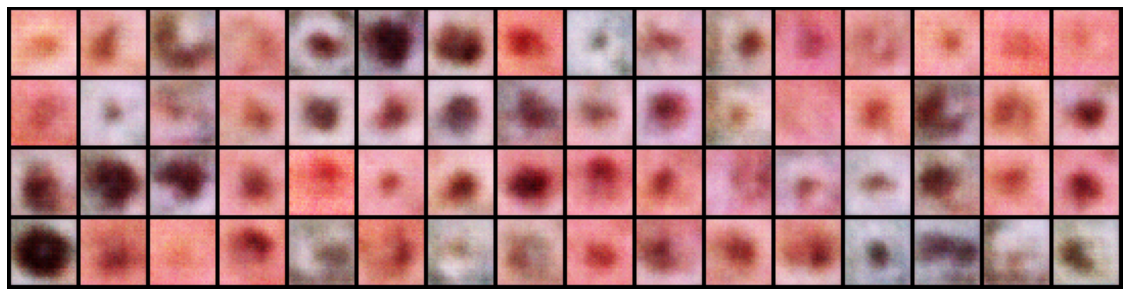

Epoch 2/50
------------------------------
 Avg. Discriminator loss: 1.1505, Avg Generator loss: 1.1199

Epoch 3/50
------------------------------
 Avg. Discriminator loss: 1.1870, Avg Generator loss: 1.0979

Epoch 4/50
------------------------------
 Avg. Discriminator loss: 1.2109, Avg Generator loss: 1.0695

Epoch 5/50
------------------------------
 Avg. Discriminator loss: 1.2200, Avg Generator loss: 1.0431

Epoch 6/50
------------------------------
 Avg. Discriminator loss: 1.2353, Avg Generator loss: 1.0316

Epoch 7/50
------------------------------
 Avg. Discriminator loss: 1.2396, Avg Generator loss: 1.0265

Epoch 8/50
------------------------------
 Avg. Discriminator loss: 1.2481, Avg Generator loss: 1.0289

Epoch 9/50
------------------------------
 Avg. Discriminator loss: 1.2509, Avg Generator loss: 1.0230

Epoch 10/50
------------------------------
 Avg. Discriminator loss: 1.2560, Avg Generator loss: 1.0325

Epoch 11/50
------------------------------
 Avg. Discriminator 

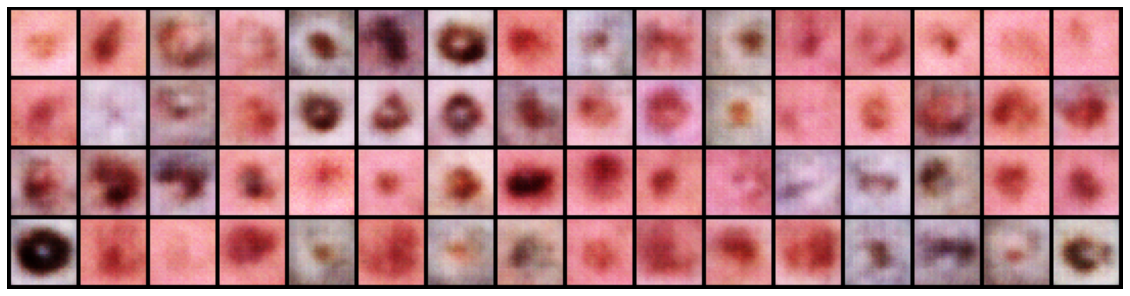

Epoch 12/50
------------------------------
 Avg. Discriminator loss: 1.2556, Avg Generator loss: 1.0315

Epoch 13/50
------------------------------
 Avg. Discriminator loss: 1.2615, Avg Generator loss: 1.0348

Epoch 14/50
------------------------------
 Avg. Discriminator loss: 1.2642, Avg Generator loss: 1.0396

Epoch 15/50
------------------------------
 Avg. Discriminator loss: 1.2633, Avg Generator loss: 1.0417

Epoch 16/50
------------------------------
 Avg. Discriminator loss: 1.2633, Avg Generator loss: 1.0491

Epoch 17/50
------------------------------
 Avg. Discriminator loss: 1.2674, Avg Generator loss: 1.0480

Epoch 18/50
------------------------------
 Avg. Discriminator loss: 1.2684, Avg Generator loss: 1.0507

Epoch 19/50
------------------------------
 Avg. Discriminator loss: 1.2683, Avg Generator loss: 1.0514

Epoch 20/50
------------------------------
 Avg. Discriminator loss: 1.2683, Avg Generator loss: 1.0577

Epoch 21/50
------------------------------
 Avg. Discri

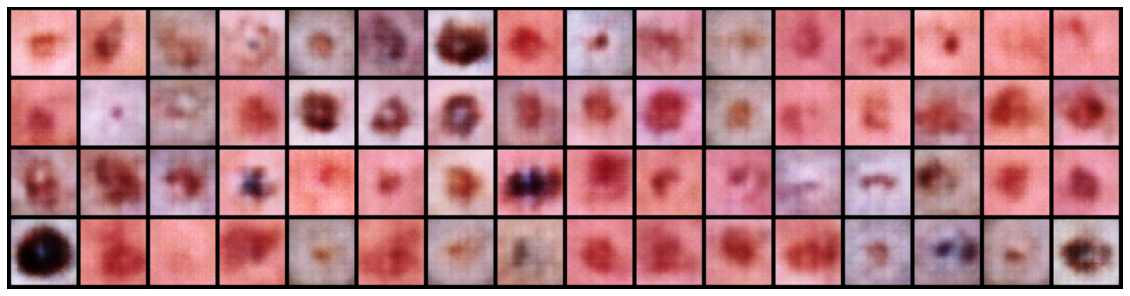

Epoch 22/50
------------------------------
 Avg. Discriminator loss: 1.2676, Avg Generator loss: 1.0661

Epoch 23/50
------------------------------
 Avg. Discriminator loss: 1.2683, Avg Generator loss: 1.0692

Epoch 24/50
------------------------------
 Avg. Discriminator loss: 1.2671, Avg Generator loss: 1.0757

Epoch 25/50
------------------------------
 Avg. Discriminator loss: 1.2648, Avg Generator loss: 1.0798

Epoch 26/50
------------------------------
 Avg. Discriminator loss: 1.2640, Avg Generator loss: 1.0838

Epoch 27/50
------------------------------
 Avg. Discriminator loss: 1.2622, Avg Generator loss: 1.0877

Epoch 28/50
------------------------------
 Avg. Discriminator loss: 1.2629, Avg Generator loss: 1.0897

Epoch 29/50
------------------------------
 Avg. Discriminator loss: 1.2608, Avg Generator loss: 1.0956

Epoch 30/50
------------------------------
 Avg. Discriminator loss: 1.2601, Avg Generator loss: 1.0998

Epoch 31/50
------------------------------
 Avg. Discri

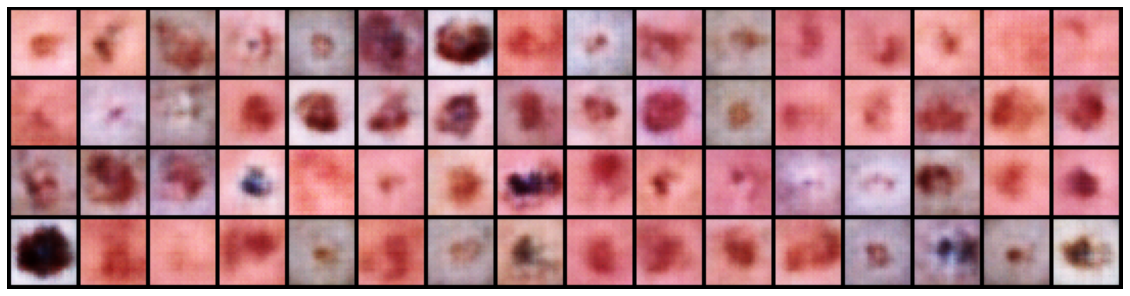

Epoch 32/50
------------------------------
 Avg. Discriminator loss: 1.2549, Avg Generator loss: 1.1116

Epoch 33/50
------------------------------
 Avg. Discriminator loss: 1.2535, Avg Generator loss: 1.1172

Epoch 34/50
------------------------------
 Avg. Discriminator loss: 1.2511, Avg Generator loss: 1.1234

Epoch 35/50
------------------------------
 Avg. Discriminator loss: 1.2511, Avg Generator loss: 1.1270

Epoch 36/50
------------------------------
 Avg. Discriminator loss: 1.2489, Avg Generator loss: 1.1314

Epoch 37/50
------------------------------
 Avg. Discriminator loss: 1.2483, Avg Generator loss: 1.1348

Epoch 38/50
------------------------------
 Avg. Discriminator loss: 1.2439, Avg Generator loss: 1.1415

Epoch 39/50
------------------------------
 Avg. Discriminator loss: 1.2428, Avg Generator loss: 1.1478

Epoch 40/50
------------------------------
 Avg. Discriminator loss: 1.2397, Avg Generator loss: 1.1538

Epoch 41/50
------------------------------
 Avg. Discri

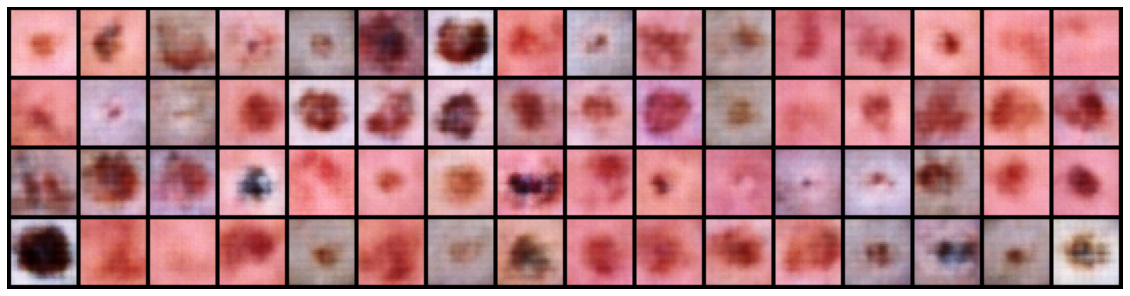

Epoch 42/50
------------------------------
 Avg. Discriminator loss: 1.2351, Avg Generator loss: 1.1663

Epoch 43/50
------------------------------
 Avg. Discriminator loss: 1.2330, Avg Generator loss: 1.1737

Epoch 44/50
------------------------------
 Avg. Discriminator loss: 1.2303, Avg Generator loss: 1.1817

Epoch 45/50
------------------------------
 Avg. Discriminator loss: 1.2289, Avg Generator loss: 1.1893

Epoch 46/50
------------------------------
 Avg. Discriminator loss: 1.2262, Avg Generator loss: 1.1947

Epoch 47/50
------------------------------
 Avg. Discriminator loss: 1.2207, Avg Generator loss: 1.2050

Epoch 48/50
------------------------------
 Avg. Discriminator loss: 1.2179, Avg Generator loss: 1.2145

Epoch 49/50
------------------------------
 Avg. Discriminator loss: 1.2144, Avg Generator loss: 1.2240

Epoch 50/50
------------------------------
 Avg. Discriminator loss: 1.2083, Avg Generator loss: 1.2365



In [26]:
display_every = 10
num_epochs = 50

G_losses = []
D_losses = []

for epoch in range(num_epochs):
        
    #for each batch in the train loader
    for batch_idx, real_imgs in enumerate(unlabeled_loader):

        num_imgs = real_imgs.size()[0]
        
        real_imgs.to(device)
               
        ###############################################################
        #                                                             #
        # Update Discirminator: maximize log(D(x)) + log(1 - D(G(z))) #
        #                                                             #
        ###############################################################
                  
        optimizerD.zero_grad()
              
        #################### Train with real images ###################
        
        labels = torch.full((num_imgs,), real_label, dtype=torch.float, device = device)
       
        output = netD(real_imgs).view(-1)
        
        # Discriminator losses on real images
        real_lossD =  loss_fn(output, labels)
        
        # compute the gradients for Discriminator in backward pass
        real_lossD.backward() #retain_graph=True
                
        ################### Train with fake images ########################
        
        # generate batch of latent vectors - tensors with random numbers from the standart normal distr 
        noise = torch.randn(num_imgs, z_dim, 1, 1, device=device)
        
        # generate batch of fake images 
        fake_imgs = (netG(noise)+1.0)/2.0
        
        labels = torch.full((num_imgs,), fake_label, dtype=torch.float, device = device)
        
        # classify the batch of fake images with the Discriminator
        output = netD(fake_imgs.detach()).view(-1) 
        
        # compute the Discriminator losses on batch of fake images
        fake_lossD =  loss_fn(output, labels) #output.squeeze()
        
        # compute the gradient of the fake images loss w.r.t. Discriminator model parameters
        fake_lossD.backward() #retain_graph=True
        
        # add up losses from classifing a batch of real and  a batch of fake images
        lossD = real_lossD + fake_lossD
    
        #save losses for ploting
        D_losses.append(lossD.item())
        
        # update the Discriminator weights
        optimizerD.step()   
           
        ###############################################################
        #                                                             #
        #           Update Generator: maximize log(D(G(z)))           #
        #                                                             #
        ###############################################################
        
        optimizerG.zero_grad()
            
        # since the generator's goal is to get netD(fake_images) = 1, flip the labels for computing Generator's loss
        labels = torch.full((num_imgs,), real_label, dtype=torch.float, device = device)    
        
        # perform another forward pass with the batch of fake images through the Discriminator, after it was updated in the previus step
        output = netD(fake_imgs).view(-1)
        
        # compute the Generator's loss on this output
        lossG = loss_fn(output, labels) 
        
        # save losses for plotting
        G_losses.append(lossG.item())
        
        # compute the gradient of the fake images (called "real") loss w.r.t. Generator model parameters
        lossG.backward()
        
        # update the Generator weights
        optimizerG.step()
        
        ###############################################################
        #                                                             #
        #                    Output training stats                    #
        #                                                             #
        ###############################################################
        
    # print out training stats
    print('Epoch {}/{}'.format(epoch+1, num_epochs))
    print('-'*30)
    print(' Avg. Discriminator loss: {:6.4f}, Avg Generator loss: {:6.4f}'.format(sum(D_losses)/len(D_losses), sum(G_losses)/len(G_losses)))
    print()  
    
    # check how the Generator is doing by displaing the fixed noise generated fake images
    if epoch % display_every == 0:
        netG.eval()
        with torch.no_grad():
            generated = (netG(fixed_noise).detach().cpu()+1.0)/2.0
            
            image_grid = torchvision.utils.make_grid(generated, normalize=True, nrow=16)
        
            print("Epoch ", epoch + 1)
            plt.figure(figsize=(20,10))
            plt.imshow(image_grid.permute(1, 2, 0))
            plt.axis("off")
            plt.pause(0.05)
        netG.train()    
        

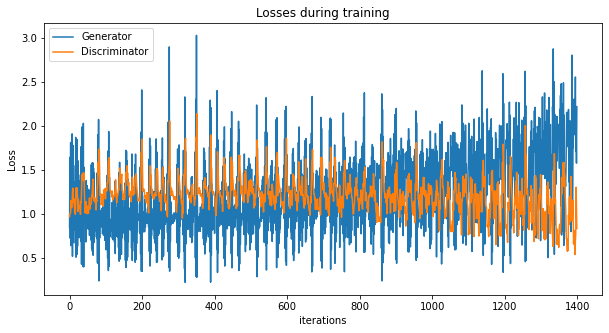

In [27]:
plt.figure(figsize=(10,5))
plt.title("Losses during training")
plt.plot(G_losses, label="Generator")
plt.plot(D_losses, label="Discriminator")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Semi-supervised GAN

A GAN with a classifying discriminator would be able to exploit both the unlabeled as well as the labeled data. The unlabeled data will be used to tell fake from real. The labeled data would be used to optimize the classification performance.


In [28]:
def create_dir(directory):
    
    """Creates a directory if it does not already exist."""
    if not os.path.exists(directory):
        os.makedirs(directory)
   

In [29]:
data_root = os.path.join(path, parent, 'Data/')
gener_img_dir = "generated_Melanoma"
check_pt_dir = "/models_wts/Melanoma_SGAN/"

create_dir(data_root + gener_img_dir)
create_dir(path + check_pt_dir)

In [30]:
def checkpoint(epoch, G, D, optimizerG, optimizerD, lossG, lossD):
    """
    Saves the parameters of the generator G and discriminator D
    and other checkpoints for finetuning, Adam optimizer has internal
    parameters which would be reset to default values
    """
    Melanoma_SGAN_path = os.getcwd() + check_pt_dir + 'SGAN.pkl'  
    # serializes the object with python pickle
    torch.save({
            'epoch': epoch,
            'G_state_dict': G.state_dict(),
            'D_state_dict': D.state_dict(),
            'optimizerG_state_dict': optimizerG.state_dict(), #
            'optimizerD_state_dict': optimizerD.state_dict(),
            'lossG': lossG,
            'lossD': lossD
            }, Melanoma_SGAN_path)
    
def load_checkpoint(model, check_pt_name):
    # unpickling to deserialize the saved object with torch.load; 
    model.load_state_dict(torch.load(os.getcwd() + check_pt_dir + check_pt_name))

In [31]:
best_model_path = os.getcwd() + check_pt_dir + "best_discriminator_wts.pkl"

In [32]:
print(best_model_path)

/Users/elliemcintosh/Documents/Python/ManningBooks_LiveProjects/MelanomaDetection/GitRepo/models_wts/Melanoma_SGAN/best_discriminator_wts.pkl


In [55]:
num_classes = 2

class Discriminator(nn.Module):
    
    
    def __init__(self, num_classes):
        super(Discriminator, self).__init__()
        
        self.conv1 = nn.Conv2d(nc, ndf, kernel_size=2, stride=2, padding=2, bias=False)
        self.conv2 = nn.Conv2d(ndf, ndf*2, kernel_size=4, stride=2, padding=1, bias=False)
        self.batchn1 = nn.BatchNorm2d(ndf*2)
        self.conv3 = nn.Conv2d(ndf*2, ndf*4, kernel_size=4, stride=2, padding=1, bias=False)
        self.batchn2 = nn.BatchNorm2d(ndf*4)
        self.conv4 = nn.Conv2d(ndf*4, ndf*2, kernel_size=4, stride=1, padding=0, bias=False)
        
        # fully connected layer with 2 output classes
        self.fc1     = nn.Linear(ndf*2, num_classes, bias=False) 
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, input):
        x = self.conv1(input)
        x = F.leaky_relu(x, 0.2, inplace=True)
        x = self.conv2(x)
        x = self.batchn1(x)
        x = F.leaky_relu(x, 0.2, inplace=True)
        x = self.conv3(x)
        x = self.batchn2(x)
        x = F.leaky_relu(x, 0.2, inplace=True)
        x = self.conv4(x)
        
        # flatten into a logits layer
        x = x.view(-1, ndf*2)
         
        logits = self.fc1(x)
        features = self.softmax(logits)
        
        return logits, features
        

In [56]:
#create and initialize the generator and discriminator
netG = Generator().to(device)
netD = Discriminator(num_classes).to(device)

netG.apply(weights_init)
netD.apply(weights_init)

Discriminator(
  (conv1): Conv2d(3, 64, kernel_size=(2, 2), stride=(2, 2), padding=(2, 2), bias=False)
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (batchn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (batchn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (fc1): Linear(in_features=128, out_features=2, bias=False)
  (softmax): Softmax(dim=1)
)

## Losses and Optimizers

Discriminator classifies the labeled data with **supervised loss** which takes the softmax ooutput (multidim normalized exponential) of the the unnormalized logits. The discriminator also separates the fake from real with **unsupervised loss**, being the log-probability of the fake class. 

We fix the unnormalized logit at 0 for an image to be fake, than the probability of it being real turns into:

\begin{equation*}
p(x) =  \frac{Z(x)}{Z(x) + exp(l_fake)} = 
\frac{Z(x)}{Z(x) + 1} \\
Z(x) = {sum(exp(l_1, l_2, ... , l_K))}
\end{equation*}

is the sum of the unnormalized probabilities. We use the log-probabilities to define the unsupervised loss function. The log representation of probability p(x):

\begin{equation*}
\log(p(x)) = {log(Z(x)) - log(1 + Z(x))} 
           = {{logsumexp(l_1, l_2, ... ,l_k)} - softplus{(logsumexp(l_1, l_2, ... ,l_k))}} \\
{softplus(x)} = {log(1 + x)} \\
\end{equation*}
is the **softplus function** of the individual logits. Use the LogSumExp -logarithm of the sum of the exponential of the arguments, a multivariable smooth approximation of the maximum.

Training GAN requires to mazimize

\begin{equation*}
\log(D(x)) + log(1-D(G(z)))
\end{equation*}

or minimize

\begin{equation*}
\log\biggl(D(x)) + log(1-D(G(z))\biggr) = 
\log\biggl(\frac{Z(x)}{Z(x) + 1}\biggr) - log\biggl(1 - \frac{Z(G(z))}{1 + Z(G(z)) } \biggr)= \\
softplus{(logsumexp(l_1^{(x)}, l_2^{(x)}, ... ,l_k^{(x)}))} -{logsumexp(l_1^{(x)}, l_2^{(x)}, ... ,l_k^{(x)})} - \\
softplus{(logsumexp(l_1^{G(z)}, l_2^{G(z)}, ... ,l_k^{G(z)}))}
\end{equation*}


In [57]:
#Set up Adam optimizers for the Generator and Discriminator
optimizerG = optim.Adam(netG.parameters(), lr = lr, betas=(beta1, 0.999))
optimizerD = optim.Adam(netD.parameters(), lr = lr, betas=(beta1, 0.999))

### Training 

Part of the training procedure is adversarial training and the other part is supervised learning. The discriminator will take:

* the ‘fake’ images coming from the generator
* a batch of unlabeled images 
* a batch of labeled images

Besides separating fake from real the discriminator will also classifies the labeled data. For this, use a supervised loss which takes the softmax output. 

In [58]:
def test(model, device, data_loader, display=True):
    
    """Evaluates the model's performance on validation or test dataset"""

    test_loss = 0
    correct = 0

    test_acc = []

    model.eval()
    with torch.no_grad():
        
        for imgs, labels in data_loader:
            
            imgs   = imgs.to(device)
            labels = labels.to(device) 
            
            logits_real_lab, features_real_lab = model(imgs)
            
            test_loss = F.cross_entropy(features_real_lab, labels).item() #torch.mean????
            predicted = features_real_lab.argmax(dim=1, keepdim=True)
            
            correct += predicted.eq(labels.view_as(predicted)).sum().item()
    
    test_loss /= len(data_loader.dataset)

    if display:
        print('\nAverage Loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss, correct, len(data_loader.dataset), 100. * correct/len(data_loader.dataset)))
           
    return np.round(test_loss, 4), np.round(100.*(correct/len(data_loader.dataset)), 2)


In [59]:
labeled_batch = next(iter(labeled_loader))
labeled_imgs = labeled_batch[0].to(device)
labels = labeled_batch[1].to(device)

num_epochs = 50

# Lists to keep track of progress
G_losses = []
D_losses = []

epoch_losses = []
train_loss = []
train_cntr = []

val_losses =[]
val_accuracies =[]

fixed_fake_list = []

best_model_wts = torch.save(netD.state_dict(), "best_discriminator_wts")
best_acc = 0.0

for epoch in range(num_epochs):
    
    print("\nEpoch {}/{}".format(epoch +1, num_epochs))
    print('-'*30)
            
    #for each iteration
    for batch in unlabeled_loader:
        
        num_imgs = batch.size()[0]
  
            
        #################### TRAIN THE DISCRIMINATOR ############
        
        netD.train()
        optimizerD.zero_grad() 
        
        # On Unlabeled Data
        
        images_unl = batch.to(device)
        
        logits_real_unl, _ = netD(images_unl)
        
        logits_sum_unl = torch.logsumexp(logits_real_unl, dim=1)
        
        loss_unl = 0.5 * (- torch.mean(logits_sum_unl) + torch.mean(F.softplus(logits_sum_unl)))
        loss_unl.backward()
        
        # On Generated Data
        
        noise = torch.randn(num_imgs, z_dim, 1, 1, device=device)
        fake_imgs = (netG(noise) + 1.0)/2.0   #convert from [-1, 1] to [0, 1]
                      
        logits_fake, _  = netD(fake_imgs.detach()) # detach() because we are not training G here
        logits_sum_fake = torch.logsumexp(logits_fake, dim=1)
        
        lossD = 0.5 * torch.mean(F.softplus(logits_sum_fake))
        lossD.backward()
                
        # On Labeled Images 
        
        _, features_real_lab  = netD(labeled_imgs)
        
        loss_labeled = torch.mean(F.cross_entropy(features_real_lab, labels))
        loss_labeled.backward() 
    
        optimizerD.step()
        
                
        ###################### TRAIN THE GENERATOR ########################################
        
        netG.train()
        optimizerG.zero_grad()
        
        logits_fake, _  = netD(fake_imgs)                  
        logits_sum_fake = torch.logsumexp(logits_fake, dim=1)
        lossG = 0.5 * (- torch.mean(logits_sum_fake) + torch.mean(F.softplus(logits_sum_fake)) )                  
        lossG.backward()
        
        optimizerG.step()
        
        # save losses for plotting
        G_losses.append(lossG.item())
        D_losses.append(lossD.item())
                
        # Validation loss and accuracy
        val_loss, val_accuracy = test(netD, device, val_loader, False)
        
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        if val_accuracy > best_acc:
            best_acc = val_accuracy
            best_discriminator_wts = torch.save(netD.state_dict(), os.getcwd() + check_pt_dir + "best_discriminator_wts.pkl")
    
            print("Discriminator best Validation Accuracy {:.2f} %".format(best_acc))
            checkpoint(epoch, netG, netD, optimizerG, optimizerD, G_losses, D_losses)
            


Epoch 1/50
------------------------------
Discriminator best Validation Accuracy 46.67 %
Discriminator best Validation Accuracy 50.00 %
Discriminator best Validation Accuracy 66.67 %
Discriminator best Validation Accuracy 71.67 %
Discriminator best Validation Accuracy 73.33 %

Epoch 2/50
------------------------------

Epoch 3/50
------------------------------

Epoch 4/50
------------------------------

Epoch 5/50
------------------------------

Epoch 6/50
------------------------------
Discriminator best Validation Accuracy 76.67 %

Epoch 7/50
------------------------------
Discriminator best Validation Accuracy 78.33 %

Epoch 8/50
------------------------------
Discriminator best Validation Accuracy 81.67 %

Epoch 9/50
------------------------------

Epoch 10/50
------------------------------

Epoch 11/50
------------------------------

Epoch 12/50
------------------------------

Epoch 13/50
------------------------------

Epoch 14/50
------------------------------
Discriminator bes

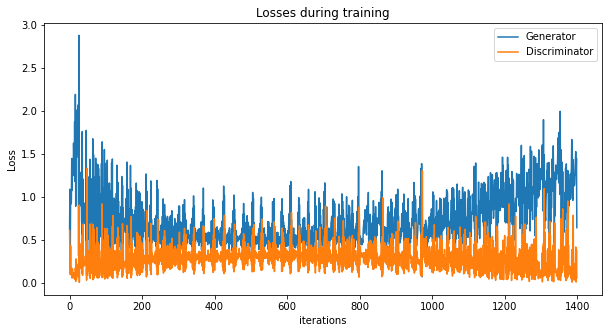

In [60]:
plt.figure(figsize=(10,5))
plt.title("Losses during training")
plt.plot(G_losses, label="Generator")
plt.plot(D_losses, label="Discriminator")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

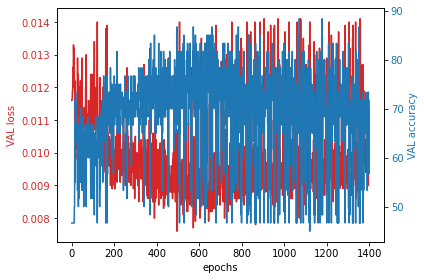

Highest accuracy on the VAL set:  88.33


In [61]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('epochs')
ax1.set_ylabel('VAL loss', color=color)
ax1.plot(range(len(np.array(val_losses))), np.array(val_losses), color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx() 

color = 'tab:blue'
ax2.set_ylabel('VAL accuracy', color=color)  
ax2.plot(range(len(np.array(val_losses))), np.array(val_accuracies), color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  
plt.show()
   
print('Highest accuracy on the VAL set: ', np.max(val_accuracies))

In [62]:
# load best model weights
netD.load_state_dict(torch.load(best_model_path))

test_loss, test_acc = test(netD, device, test_loader, display=False) 
print("\nBest SGAN model test accuracy: ",test_acc)


Best SGAN model test accuracy:  79.17


### Melanoma Classifier models performance comparison

Compare the test accuracies of the Melanoma classifiers:

* Supervised model trained from scratch: 78%
* Supervised transfer learning DenseNet121: 76%
* Semi-supervised GAN: 79%

The semi-supervised model attains higher accuracy than both supervised models trained from scratch and pre-trained on the ImageNet. Further improvements may be limited by the small number of labeled samples, but also by the low resolution of the images and the difficulty of the classification task, which poses a problem even for experienced medical professionals. 

### Test on labeled, unlabeled and new images

In [63]:
def classify(model, images, num_images):
    
    """ A function that predicts the class of specified 
        num_images and returenes the classified images 
        with a class. Input images need to be in Pillow 
        format."""
    
    try:
        if num_images != len(images):
            raise ValueError("Choose a number of images, less than or equal to {} ".format(len(images)))
    except ValueError as err:
        print(err)
    
    model.eval()
    with torch.no_grad():
        
        _, class_out = model(images)
        
        pred = torch.argmax(class_out, dim=1) 
        
        labels = [class_names[int(pred.tolist()[i])] for i in range(num_images)]
    
        # slice off the required number of imaages to be classified from the input set of images
        class_imgs = torch.narrow(images, dim=0, start=0, length=num_images)        
    
    return class_imgs, labels

In [65]:
def display_images(images, pred_labels, true_labels=[], nrows=4, ncols=4):
    
    """ Helper function for displaying images 
        with their true and predicted labels """
    try:
        if len(images)!= len(pred_labels):
            raise ValueError("Number of images different than number of labels {} ".format(len(labels)))
    except ValueError as err:
        print(err) 
            
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12,12))
    #fig.suptitle("Images of batch number {}".format(batch_idx), fontsize=14)
    
    n = 0 
    for i in range(nrows):
        
        for j in range(ncols):
            
            img_idx = i + j + (ncols-1)*n
            
            if true_labels ==[]:
                img_labels = pred_labels[img_idx]
                
            else:
                img_labels = true_labels[img_idx] + "\n predicted: " + pred_labels[img_idx]
                   
            img_tensor = images.cpu().data[img_idx]
            
            # convert into numpy array 
            img_array = img_tensor.numpy().transpose((1, 2, 0))
            
            axes[i,j].imshow(img_array)
            axes[i,j].set_title(img_labels, fontsize=10)
            axes[i,j].axis('off')
        
        n += 1

Choose a number of images, less than or equal to 140 


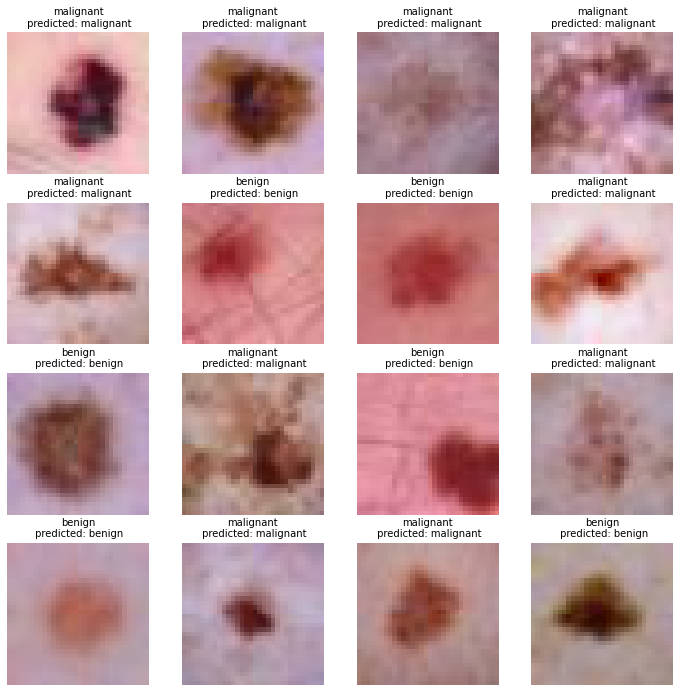

In [66]:
num_images = 16
class_names = ["benign", "malignant"]

dataiter = iter(labeled_loader)
images, ground_truth = dataiter.next()

true_labels = [class_names[int(ground_truth.tolist()[i])] for i in range(num_images) ]

class_imgs, pred_labels = classify(netD, images, num_images)

display_images(class_imgs, pred_labels, true_labels) 

Choose a number of images, less than or equal to 256 


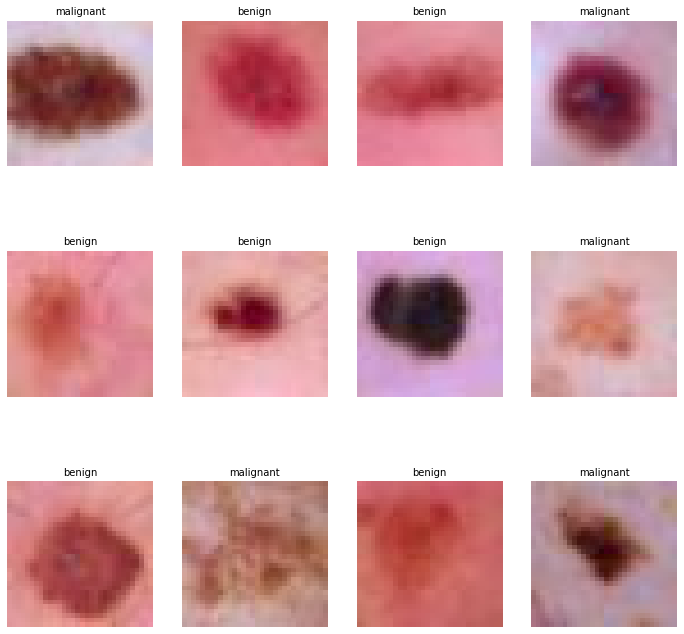

In [67]:
num_images = 12
class_names = ["benign", "malignant"]

dataiter = iter(unlabeled_loader)
images = dataiter.next()

class_imgs, pred_labels = classify(netD, images, num_images)
display_images(class_imgs, pred_labels, nrows=3, ncols=4) 

In [85]:
new_data_path = os.path.join(path, parent, 'Data/moles/')

print(new_data_path)

/Users/elliemcintosh/Documents/Python/ManningBooks_LiveProjects/MelanomaDetection/Data/moles/


In [89]:
print(len([name for name in os.listdir(new_data_path) if os.path.isfile(os.path.join(new_data_path, name))]))

16


In [93]:
transform=transforms.Compose([transforms.Resize((32, 32), interpolation=Image.NEAREST), 
                              transforms.ToTensor()])

new_data_path = os.path.join(path, parent, 'Data/moles/')

print("Number of images in folder: ", \
      len([name for name in os.listdir(new_data_path) if os.path.isfile(os.path.join(new_data_path, name))]))

new_set = UnlabeledDataset(dir_path= new_data_path, transform=transform)

newimgs_loader = DataLoader(dataset = new_set,
                            batch_size = len(new_set),
                            num_workers = 0,
                            shuffle=False)

print('Number of images in the new data set: ', len(newimgs_loader.dataset))

Number of images in folder:  16
Number of images in the new data set:  16


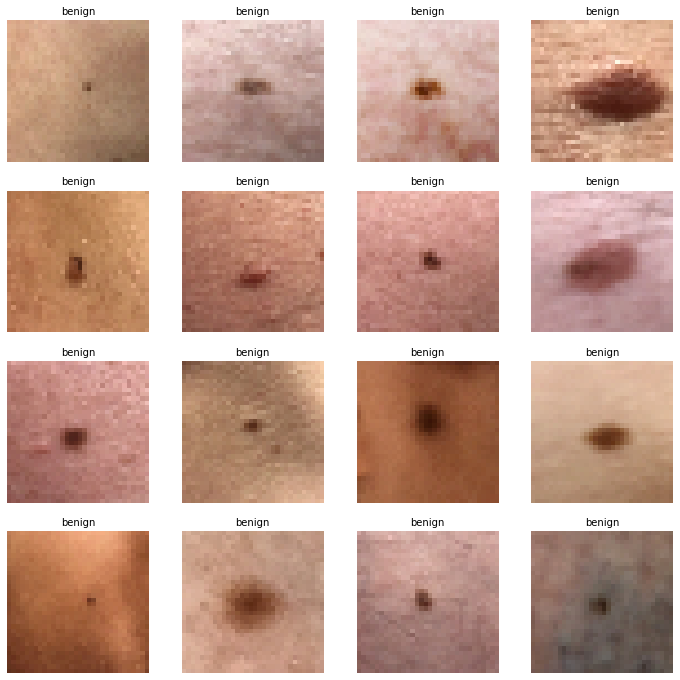

In [94]:
num_images = 16
                                         
dataiter = iter(newimgs_loader)
new_images = (dataiter.next() + 1.)/2.

class_imgs, pred_labels = classify(netD, new_images, num_images)
display_images((2.*class_imgs -1), pred_labels) 